In [50]:
# %load ../init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import numpy as np
import holodeck as holo
import holodeck.single_sources as ss
from holodeck.constants import YR
import matplotlib.pyplot as plt
import scipy as sp

In [157]:
edges, number, fobs, exname = ss.example5(print_test=False)
hc_bg, hc_ss, ssidx, hsamp, bgpar, sspar = ss.ss_by_cdefs(edges, number, 30, params=True)
# example 5
dur5 = 10.0*YR
cad5 = .2*YR
# dur4 = 5.0*YR/3.1557600
# cad4 = .2*YR/3.1557600

using default mtot, mrat, and redz
00:05:07 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
00:05:07 INFO : Stalled SAM bins based on GMT: 1.98e+05/4.99e+05 = 3.96e-01 [sam.py:static_binary_density]
00:05:08 INFO : Adding MMbulge scatter (3.4000e-01) [sam.py:static_binary_density]
00:05:08 INFO : 	dens bef: (1.28e-114, 5.22e-53, 2.59e-13, 2.12e-03, 1.66e-02, 2.92e-02, 4.47e-02) [sam.py:static_binary_density]
00:05:14 INFO : Scatter added after 5.99839 sec [sam.py:static_binary_density]
00:05:14 INFO : 	dens aft: (6.14e-17, 7.92e-09, 2.90e-06, 2.19e-03, 1.69e-02, 2.92e-02, 4.27e-02) [sam.py:static_binary_density]
00:05:14 INFO : 	mass: 8.56e-02 ==> 8.54e-02 || change = -1.8507e-03 [sam.py:static_binary_density]
00:05:14 INFO : zeroing out 1.98e+05/4.99e+05 = 3.96e-01 systems stalled from GMT [sam.py:static_binary_density]
00:05:14 INFO : fraction of coalesced binaries: 4.33e+05/1.25e+07 = 3.47e-02 [sam.py:dynamic_binary_number]
00:05:14 WARNING : WARNING: _

# Rosado et al 2015

## For GWB
PDF in the absence of a GWB
$$ p_0(S) = \frac{1}{\sqrt{2\pi\sigma_0^2} }e^{-\frac{(S-\mu_0)^2}{2\sigma_0^2}} $$
PDF if GWB is present in the data
 $$ p_1(S) = \frac{1}{\sqrt{2\pi\sigma_1^2} }e^{-\frac{(S-\mu_1)^2}{2\sigma_1^2}} $$

cross correlation
$$ S = \int_{-T/2}^{T/2} dt \int_{-T/2}^{T/2} dt' s_i(t) s_j(t') Q(t,t')$$
$T$ = observing time, $s_i(t)$ and $s_j(t)$ are different pulsar data, $Q(t,t')$ = filter function, chosen to maximize DP for a fixed FAP $=\alpha_0=0.001$ (Neyman-Pearson criterion)


## For single sources
PDF of $\mathcal{F}_e$ - statistic in absence of signal
$$ p_0(\mathcal{F}_e) = \mathcal{F}_e e^{-\mathcal{F}_e}$$
PDF of $\mathcal{F}_e$ - statistic if signal is present
$$ p_1(\mathcal{F}_e, \rho) = \frac{(2\mathcal{F}_e)^{1/2}}{\rho} I_1 (\rho \sqrt{2 \mathcal{F}_e}) e^{-\mathcal{F}_e - 1/2\rho^2} $$
where $I_1(x)$ = the modified Bessel function of the first kind of order 1 and
 $\rho$ = the optimal $S/N_S = \big[ \sum_{i=1}^M S/N_i^2 \big]^{1/2}$

## Detection probability
for single sources: $ \gamma_S(t) = \int_0^t p_s(t') dt'$ \
for background: $ \gamma_B(t) = \int_0^t p_B(t') dt'$

# Variables
* $\alpha$ = false alarm probability
* $\gamma$ = detection probability
* $S_T$ = threshold signal

Background Detection Probability
$$ \gamma_{bg} = \frac{1}{2} \mathrm{erfc} \big[ \frac{\sqrt{2} \sigma_0 \mathrm{erfc}^{-1}(2\alpha_0) - \mu_1}{\sqrt{2} \sigma_1}\big]

In [52]:
ALPHA0 = 0.001 # false alarm probability (FAP)
GAMMA0 = 0.95 # detection probability

def bg_detection_probability(sigma_0, sigma_1, mu_1, alpha_0):
    """ Calculate the background detection probability, gamma_bg.

    Parameters
    ----------
    sigma_0 : scalar
        Standard deviation of stochastic noise processes.
    sigma_1 : scalar
        Standard deviation of GWB PDF.
    mu_1 : scalar
        Mean of GWB PDF.
    alpha_0 : scalar
        False alarm probability max.

    Returns
    -------
    gamma_bg : scalar
        Background detection probability.

        
    Follows Rosado et al. 2015 Eq. (15)
    """
    temp = ((np.sqrt(2) * sigma_0 * sp.erfinv(2*alpha_0) - mu_1)
            /(np.sqrt(2) * sigma_1))
    gamma_bg = .5 * sp.erf(temp)
    return gamma_bg

A-statistic: 
$$ S/N_A = \mu_1/\sigma_0$$
B-statistic:
$$ S/N_B = \mu_1 / \sigma_1 $$

In [158]:
def SNR_A(mu_1, sigma_0):
    """ Calculate the SNR for the A-statistic S/N_A 
    
    Parameters
    ----------
    mu_1 : scalar
        Mean of GWB PDF.
    sigma_0 : scalar
        Standard deviation of noise processes.

    Returns
    -------
    SNR_A : scalar
        Signal to noise ratio for the A-statistic.
    """
    return mu_1/sigma_0

def SNR_B(mu_1, sigma_1):
    """ Calculate the SNR for the B-statistic S/N_B.

    Parameters
    ----------
    mu_1 : scalar
        Mean of GWB PDF.
    sigma_1 : scalar
        Standard deviation of the GWB PDf.

    Returns
    -------
    SNR_B : scalar
        Signal to noise ratio for the B-statistic.
    """
    return mu_1/sigma_1

Threshold signal to noise to have FAP $\alpha <\alpha_0$ and detection probability $\gamma > \gamma_0$

$$ \mathrm{S/N^T_A} = \sqrt{2} \big[ \mathrm{erfc}^{-1}(2\alpha_0) - \frac{\sigma_1}{\sigma_0}\mathrm{erfc}^{-1}(2 \gamma_0) \big] $$

$$\mathrm{S/N^T_B} = \sqrt{2} \big[ \frac{\sigma_0}{\sigma_1} \mathrm{erfc}^{-1}(2\alpha_0) - \mathrm{erfc}^{-1}(2 \gamma_0) \big] $$

$$ \mathrm{S/N^T} \approx \sqrt{2} \big[ \mathrm{erfc}^{-1}(2\alpha_0) - \mathrm{erfc}^{-1}(2 \gamma_0) \big] $$

In [54]:
def SNR_A_thresh(sigma_0, sigma_1, alpha_0, gamma_0):
    """ Calculate the threshold SNR for the A-statistic S/N^T_A 
    to have a FAP < alpha_0 and DP > gamma_0.
    
    Parameters
    ----------
    sigma_0 : scalar
        Standard deviation of noise processes.
    sigma_1 : scalar
        Standard deviation of the GWB
    alpha_0 : scalar
        False alarm probability max.
    gamma_0 : scalar
        Detection probability min.

    Returns
    -------
    SNT_A : scalar
        Signal to noise ratio for the A-statistic.

    Follows Rosado et al. 2015 Eq. (18)
    """
    SNT_A = np.sqrt(2) * (sp.erfinv(2*alpha_0) 
                          - sigma_1/sigma_0 * sp.erfinv(2*gamma_0))
    return SNT_A

def SNR_B(sigma_0, sigma_1, alpha_0, gamma_0):
    """ Calculate the threshold SNR for the B-statistic S/N^T_B
    to have a FAP < alpha_0 and DP > gamma_0.
    
    Parameters
    ----------
    sigma_0 : scalar
        Standard deviation of noise processes.
    sigma_1 : scalar
        Standard deviation of the GWB
    alpha_0 : scalar
        False alarm probability max.
    gamma_0 : scalar
        Detection probability min.

    Returns
    -------
    SNT_B : scalar
        Signal to noise ratio for the A-statistic.

    Follows Rosado et al. 2015 Eq. (19)
    """
    SNT_B = np.sqrt(2) * (sigma_0/sigma_1 * sp.erfinv(2*alpha_0) 
                          - sp.erfinv(2*gamma_0))
    return SNT_B

def SNR_approx_thresh(alpha_0, gamma_0):
    """ Calculate the approximate threshold SNR S/N^T for FAP < alpha_0 and DP > gamma_0/
    This approximates sigma_0 ~ sigma_1
    
    Parameters
    ----------
    alpha_0 : scalar
        False alarm probability maximum.
    gamma_0 : scalar
        Detection probability minimum.

    Returns
    -------
    SNT : scalar
        Signal to noise ratio threshold, approximated.

    Follows Rosado et al. 2015 Eq. (17)
    """
    SNT = np.sqrt(2) * (sp.erfinv(2*alpha_0) - sp.erfinv(2*gamma_0))

Overlap Reduction Function
$$ \Gamma_{ij} = \frac{3}{2} \gamma_{ij} \ln (\gamma_{ij}) - \frac{1}{4} \gamma_{ij} + \frac{1}{2} + \frac{1}{2}\delta_{ij} $$
$$ \gamma_{ij} = [1-\cos (\theta_{ij})]/2$$

In [114]:
def gammaij_from_thetaij(theta_ij):
    """ Calcualte gamma_ij for two pulsars of relative angle theta_ij.
    
    Parameters
    ----------
    theta_ij : scalar 
        Relative angular position between the ith and jth pulsars.

    Returns
    -------
    gamma_ij : scalar 
        [1 - cos(theta_ij)]/2

    """
    return (1-np.cos(theta_ij))/2

def thetaij_from_thetai_thetaj(theta_i, theta_j):
    """ Calcualte relative angle between two pulsars with angular positions theta_i and theta_j.
    
    Parameters
    ----------
    theta_i : scalar 
        Angular position in the sky of the ith pulsar.
    theta_j : scalar 
        Angular position in the sky of the jth pulsar.

    Returns
    -------
    theta_ij : scalar 
        Relative angular position between the ith and jth pulsar.

    """
    return np.abs(theta_i - theta_j)

def dirac_delta(i,j):
    """ Calculate the dirac delta function of i,j.
    Parameters
    ----------
    i : int
    j : int

    Returns
    ------- 
    dirac_ij : int
        Dirac delta function of i and j

    """
    if(i==j): return 1
    else: return 0

def overlap_from_gammaij_diracij(gamma_ij, dirac_ij):
    """ Calculate Gamma_i,j as a function of gamma_i,j and diracdelta_i,j

    Parameters
    ----------
    gamma_ij : scalar 
        (1-cos(theta_ij))/2
    dirac_ij : scalar 
        Dirac delta function of i and j.

    Returns
    -------
    Gamma_ij : scalar 
        Overlap reduction function of the ith and jth pulsars.

    Follows Rosado et al. 2015 Eq. (24)
    """
    return (3/2 * gamma_ij *np.log(gamma_ij)
            - 1/4 * gamma_ij
            + 1/2 + dirac_ij)

def overlap_reduction_function(theta_i, theta_j, i, j):
    """ Calculate the overlap reduction function Gamma_i,j as a function of theta_i, theta_j, i, and j.
    
    Parameters
    ----------
    theta_i : scalar
        Angular position of the ith pulsar.
    theta_j : scalar
        Angular position of the jth pulsar.
    i : int
        index of the ith pulsar
    j : int
        index of the jth pulsar

    Returns
    -------
    Gamma_ij : scalar
        The overlap reduction function of the ith and jth pulsars.
    """
    dirac_ij = dirac_delta(i, j)
    theta_ij = thetaij_from_thetai_thetaj(theta_i, theta_j)
    gamma_ij = gammaij_from_thetaij(theta_ij)
    # print('dirac_ij:', dirac_ij, '\ntheta_ij', theta_ij, '\ngamma_ij', gamma_ij)
    return overlap_from_gammaij_diracij(gamma_ij, dirac_ij)

In [178]:
# better to do with ndars, construct Gamma_ij as 2darray
THETAS = np.array([0, np.pi/6, np.pi, 7/6*np.pi]) # (P,) 1Darray of scalars, angular sky position of each pulsar
print(THETAS)

num = len(THETAS) # number of pulsars, P
overlap_ij = np.zeros((num, num)) # (P,P) 2Darray of scalars, Overlap reduction function between all puolsar
for ii in range(num):
    for jj in range(num):
        overlap_ij[ii,jj] = overlap_reduction_function(THETAS[ii], THETAS[jj], ii, jj)
print(overlap_ij)

[0.         0.52359878 3.14159265 3.66519143]
[[       nan 0.21162783 0.25       0.16970912]
 [0.21162783        nan 0.16970912 0.25      ]
 [0.25       0.16970912        nan 0.21162783]
 [0.16970912 0.25       0.21162783        nan]]


$S_h$, the one-sided power spectral density of the GW signal in the timing residuals
$$ S_h = \frac{h_c^2}{12 \pi ^2 f_k^3}$$

$S_{h0}$, the expected one-sided power spectral density of the GW signal
$$ S_{h0} = \frac{\mathcal{A}^2 \mathrm{yr}^{-4/3}}{12\pi^2} f^{-13/3} $$
where $\mathcal{A}$ is the fiducial characteristic strain amplitude such that 
$$h_c = \mathcal{A} [f/\mathrm{yr}^{-1}]^{-2/3}$$
Rosado et al. approximate as
$$ S_{h0} \approx S_h = \frac{h_c^2}{12 \pi ^2 f_k^3}$$

In [56]:
def power_spectral_density(h_c, f_k):
    """ Calculate the one-sided power spectral density P_i of the ith pulsar at the kth frequency.

    Parameters
    ----------
    h_c : scalar
        Characteristic strain of the ith pulsar.
    f_k : scalar
        Frequency.
    
    Returns
    -------
    S_h : scalar
        Power spectral density of the ith pulsar at the kth frequency.
        Equivalently S_h0, using Rosado+2015's approximation.

    Follows Rosado et al. 2015 Eq. (25)
    """
    S_h =  h_c**3 / (12 * np.pi**2 * f_k**3)
    return S_h

Noise spectral density $S_i$ 
$$ S_i = 2 \Delta t \sigma_i^2 + S_{h,\mathrm{rest}}$$
where $2 \Delta t \sigma_i ^2$ is the contribution from the pulsar's white noise and $S_{h,\mathrm{rest}}$ is from all the other SBHBs except for the max, in our single source detection.

In [129]:
def white_noise(delta_t, sigma_i):
    """ Calculate the white noise for a given pulsar 2 /Delta t sigma_i^2
    
    Parameters
    ----------
    delta_t : scalar
        Detection cadence, in seconds.
    sigma_i : scalar
        Error/stdev/variance? for the ith pulsar, in seconds.

    Returns
    -------
    P_i : scalar
        Noise spectral density for the ith pulsar, for bg detection.
        For single source detections, the noise spectral density S_i must also 
        include red noise from all but the loudest single sources, S_h,rest.

    """
    P_i = 2 * delta_t * sigma_i**2
    return P_i

In [177]:
SIGMAS = np.linspace(1e-5, 1e-5,4) # (P,) 1Darray of scalars, sigma_i of each pulsar
print(cad5/YR, SIGMAS/YR, 'in years') #  cad and SIGMA are in seconds
print(cad5, SIGMAS, 'in seconds') #  cad and SIGMA are in seconds

noise_i = white_noise(cad5, SIGMAS) 
print('P_i =', noise_i, 's^3 =', noise_i/YR**3,' yrs^3')

0.2 [3.16880878e-13 3.16880878e-13 3.16880878e-13 3.16880878e-13] in years
6311520.0 [1.e-05 1.e-05 1.e-05 1.e-05] in seconds
P_i = [0.0012623 0.0012623 0.0012623 0.0012623] s^3 = [4.01653964e-26 4.01653964e-26 4.01653964e-26 4.01653964e-26]  yrs^3


mu_1, sigma_0, sigma_1 when we maximize the A statistic $\mu/\sigma_0 = \langle X \rangle / \sqrt{\mathrm{var}(X)_0}$

$$ \mu_1 = 2 \sum_k \sum_{ij} \frac{\Gamma_{ij}^2 S_h S_{h0}}{P_i P_j}$$

### B-statistic

$$\mu_1 = 1\sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_h S_{h0}}{[P_i + S_{h0}] [P_j + S_{h0}] + \Gamma_{ij}^2 S_{h0}^2} $$

$$ \sigma_0^2 = 2\sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_{h0}^2 P_i P_j  }{\big[ [P_i + S_{h0}] [P_j +S_{h0}] + \Gamma_{ij}^2 S_{h0}^2  \big]^2  } $$

$$ \sigma_1^2 = 2 \sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_{h0}^2 \big[ [P_i + S_h] [P_j + S_h] + \Gamma_{ij}^2 S_h^2   \big]  }{\big[[P_i + S_{h0}][P_j + S_{h0}] + \Gamma_{ij}^2 S_{h0}^2  \big]^2  } $$


* $S_h(f_k)$ := actual value of the spectral density in the background
$$ S_h = \frac{h_c^2}{12 \pi ^2 f_k^3}$$
* $S_{h0}(f_k)$ := value of the spectral density used to construct the statistic
$$ S_{h0} \approx S_h$$
* $P_i$ = $S_i$ := noise spectral density
$$ S_i = 2 \Delta t \sigma_i^2 + S_{h,\mathrm{rest}}$$
* $2 \Delta t \sigma_i^2$ := the contribution from the pulsar's white noise
* $S_{h,\mathrm{rest}}$ := an additional red noise term produced by all other SBHBs at the same frequency bin
$$ S_{h,\mathrm{rest}} = \frac{h_{c,\mathrm{rest}}^2}{f} \frac{1}{12 \pi^2 f^2}$$


In [142]:
def spectral_density(hc_bg, freqs):
    """ Calculate the spectral density S_h(f_k) ~ S_h0(f_k) at the kth frequency

    Parameters
    ----------
    hc_bg : (F,) 1D array of scalars
        Characteristic strain of the background at each frequency. 
    freqs : (F,) 1Darray of scalars
        Frequency bin centers corresponding to each strain

    Returns
    -------
    S_h : (F,) 1Darray of scalars
        Actual (S_h) or ~construction (S_h0) value of the background spectral density. 
        In units of [freqs]^-3
    """

    S_h = hc_bg**2 / (12 * np.pi**2 * freqs**3)
    return S_h

In [179]:
print(fobs[:])
print(hc_bg[:,0])
print(len(fobs))


[3.16880878e-09 6.33761756e-09 9.50642634e-09 1.26752351e-08
 1.58440439e-08 1.90128527e-08 2.21816615e-08 2.53504703e-08
 2.85192790e-08 3.16880878e-08 3.48568966e-08 3.80257054e-08
 4.11945142e-08 4.43633229e-08 4.75321317e-08 5.07009405e-08
 5.38697493e-08 5.70385581e-08 6.02073668e-08 6.33761756e-08
 6.65449844e-08 6.97137932e-08 7.28826020e-08 7.60514108e-08
 7.92202195e-08]
[6.36090712e-15 3.59703348e-15 2.52959798e-15 2.13075888e-15
 1.92784403e-15 1.32045336e-15 1.30306950e-15 9.51058084e-16
 8.53420312e-16 7.71624708e-16 9.04182344e-16 7.29125152e-16
 5.06651582e-16 6.11270394e-16 4.36886075e-16 4.11679200e-16
 5.10948352e-16 2.75174212e-16 4.67156403e-16 5.11281363e-16
 2.62670664e-16 2.83298532e-16 4.64479117e-16 3.07575988e-16
 3.59109729e-16]
25


In [180]:
Sh_bg = spectral_density(hc_bg[:,0], fobs) # spectral density of bg, using 0th realization
Sh0_bg = Sh_bg # approximation used in Rosado et al. 2015
print(Sh_bg**3)
print(Sh_bg[8])

[1.23767625e-15 7.90477753e-20 2.48719864e-22 6.67050393e-24
 4.91127287e-25 9.82810693e-27 2.26681382e-27 1.03020842e-28
 1.86332236e-29 3.94393259e-30 4.33006780e-30 5.44094074e-31
 2.98029309e-32 4.71781144e-32 3.37971913e-33 1.32362949e-33
 2.80358967e-33 4.08965406e-35 6.01844308e-34 6.51902342e-34
 7.72660137e-36 8.00118931e-36 1.04169209e-34 5.98833542e-36
 1.05049908e-35]
2.651119670350339e-10


In [70]:
def mean1_Bstatistic_loops(noise_i, overlap_ij, Sh_bg, Sh0_bg):
    """ Calculate mu_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise_i : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    overlap_ij : (P,P,) 2Darray of scalars
        Overlap reduction function.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    mu_1B : 
        Expected value for the B statistic
    """
    mu_1B = 0
    for ii in range(len(noise_i)):
        P_i = noise_i[ii]
        for jj in range(len(noise_i)): # should ii and jj repeat, or just do for jj < ii?
            if(jj>ii):
                P_j = noise_i[jj]
                Gamma_ij = overlap_ij[ii,jj]
                for kk in range(len(Sh_bg)):
                    Sh_k = Sh_bg[kk]
                    Sh0_k = Sh0_bg[kk]
                    mu_1B += ((Gamma_ij**2 * Sh_k * Sh0_k)
                            /((P_i+Sh0_k) * (P_j+Sh0_k) 
                                + Gamma_ij**2 * Sh0_k**2))
    mu_1B *= 2
    return mu_1B

def mean1_Bstatistic_ndars(noise_i, overlap_ij, Sh_bg, Sh0_bg):
    """ Calculate mu_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    This doesn't work, it extraneously includes j<=1
    
    Parameters
    ----------
    noise_i : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    overlap_ij : (P,P,) 2Darray of scalars
        Overlap reduction function.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    mu_1B : 
        Expected value for the B statistic
    """
    
    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma_ij in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = (overlap_ij[:,:,np.newaxis] **2 
            * Sh_bg[np.newaxis, np.newaxis, :]
            * Sh0_bg[np.newaxis, np.newaxis, :])
    denom = ((noise_i[:, np.newaxis, np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
               * (noise_i[np.newaxis, :, np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
               + overlap_ij[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis, np.newaxis, :]**2)
    
    # change the sum part
    sum =0
    for ii in range(len(numer)):
        for jj in range(len(numer[0])):
            if(jj>ii):
                sum += np.sum(numer[ii,jj,:]/denom[ii,jj,:])
    mu_1B = 2*sum
    return mu_1B


In [ ]:
mu_1B_loops = mean1_Bstatistic_loops(noise_i, overlap_ij, Sh_bg, Sh0_bg)
mu_1B_ndars = mean1_Bstatistic_ndars(noise_i, overlap_ij, Sh_bg, Sh0_bg)


# Plot Gamma function

Larger $\Gamma_{ij}$ means we expect more overlap right, so what does negative $\Gamma_{ij}$ mean?

Largest overlap at $\theta_i \sim \theta_j$, next largest at $\theta_i \sim \theta_j + \pi$ e.g. $\theta_{ij} \sim 180\degree$, smallest at $\theta_{ij} \sim 90\degree$ perpendicular in the sky

Text(0.5, 1.0, '$\\gamma_{ij}(\\theta_{ij}) = [1-\\cos{(\\theta_{ij})}]/2$')

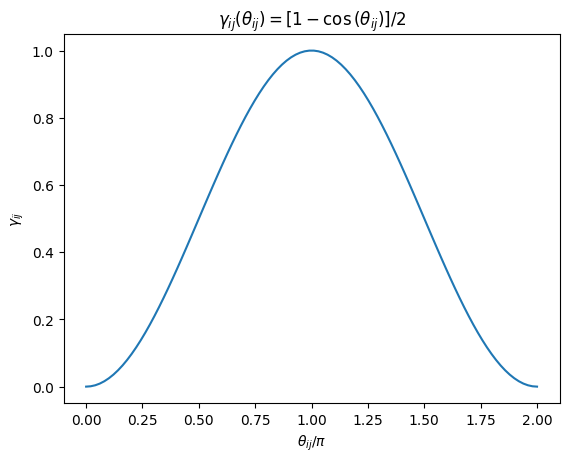

In [110]:
theta_arr = np.linspace(0,2*np.pi,100)
gamma_arr = (1-np.cos(theta_arr))/2
plt.plot(theta_arr/np.pi, gamma_arr)
plt.xlabel(r'$\theta_{ij} / \pi$')
plt.ylabel(r'$\gamma_{ij}$')
plt.title(r'$\gamma_{ij}(\theta_{ij}) = [1-\cos{(\theta_{ij})}]/2$')

Text(0.5, 1.0, '$\\Gamma_{ij}(\\theta_{ij}) = \\frac{3}{2}\\gamma_{ij} \\ln (\\gamma_{ij}) - \\frac{1}{4}\\gamma_{ij} + \\frac{1}{2}$')

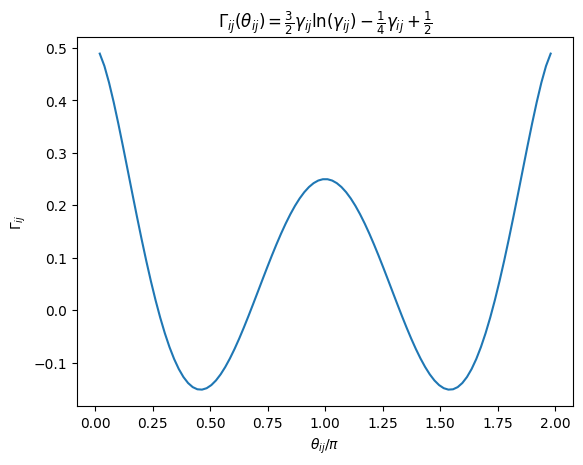

In [109]:
Gamma_arr = 3/2*gamma_arr *np.log(gamma_arr) - 1/4* gamma_arr + 1/2
plt.plot(theta_arr/np.pi, Gamma_arr)
plt.xlabel(r'$\theta_{ij} /\pi$')
plt.ylabel('$\Gamma_{ij}$')
plt.title(r'$\Gamma_{ij}(\theta_{ij}) = \frac{3}{2}\gamma_{ij} \ln (\gamma_{ij}) - \frac{1}{4}\gamma_{ij} + \frac{1}{2}$')